In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import wrds
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from scipy import stats

## The Data

In [ ]:
borisovadb=wrds.Connection()

In [ ]:
#---------------------------------------------
# Risk Free Rate 
#---------------------------------------------
Rf=db.raw_sql("""select  mcaldt,tmytm 
           from crsp.tfz_mth_rf            
            where kytreasnox = 2000001 
           and mcaldt>='1928-01-01'
            and mcaldt<='2004-12-31'""", date_cols=['mcaldt'])
Rf['tmytm']=Rf['tmytm']/12/100
Rf=Rf.rename(columns={ "mcaldt": "date","tmytm": "rf"})


#---------------------------------------------
# Value Weighted Index Returns
#---------------------------------------------
Rm=db.raw_sql("""select  date,vwretd from crsp.msi 
                where date>='1928-01-01' and date<='2004-12-31'
                """,date_cols=['date'])
Rm = Rm.rename(columns={'vwretd':'Rm'})

#---------------------------------------------
# Stock Returns 
#---------------------------------------------
stock_data = db.raw_sql("""
                    select a.permno, a.date, 
                      b.shrcd, b.exchcd,
                      a.ret, a.shrout, a.prc
                      from crsp.msf as a
                      left join crsp.msenames as b
                      on a.permno=b.permno
                      and b.namedt<=a.date
                      and a.date<=b.nameendt
                      where a.date between '01/01/1928' and '12/31/2004'
                      and b.exchcd between 1 and 2
                      and b.shrcd between 10 and 11
                      """, date_cols=['date']) 
stock_data=stock_data.drop(['shrcd','exchcd'],axis=1)
stock_data = stock_data.rename(columns={'ret':'Rn'})
stock_data['mcap'] = np.abs(stock_data['prc'])*stock_data['shrout']
stock_data['mcap_l'] = stock_data.groupby(['permno'])['mcap'].shift(1)


#---------------------------------------------
# Merge Data 
#---------------------------------------------
data = pd.merge(stock_data, Rf, on=['date'], how='left')
data = pd.merge(data, Rm, on=['date'], how='left')
data['const'] = 1
data['Rn_e'] = data['Rn']-data['rf']
data['Rm_e'] = data['Rm']-data['rf']
data.to_csv('data.csv', sep=';',index=False) # export data

## Betting against Beta strategy (BaB)

In [3]:
data_bab = pd.read_csv('data.csv', sep=';')
data_bab['date'] = pd.to_datetime(data_bab['date'])
data_bab=data_bab.sort_values(['date','permno']).reset_index(drop=True)
data_bab = data_bab.dropna(subset=['mcap_l','Rn_e','Rm_e']).copy()
data_bab['N'] = data_bab.groupby(['permno'])['date'].transform('count')
data_bab = data_bab[data_bab['N']>60].copy() # consider only those that have more than 5-years of data
data_bab

,permno,date,Rn,shrout,prc,mcap,mcap_l,rf,Rm,const,Rn_e,Rm_e,N
0,10006,1964-01-31,0.068548,2948.0,66.25000,1.953050e+05,202675.000,0.002873,0.025790,1,0.065675,0.022917,243
1,10014,1964-01-31,0.000000,3369.0,2.87500,9.685875e+03,9685.875,0.002873,0.025790,1,-0.002873,0.022917,157
3,10057,1964-01-31,0.069915,500.0,62.50000,3.125000e+04,33000.000,0.002873,0.025790,1,0.067042,0.022917,388
4,10102,1964-01-31,0.029083,5032.0,57.50000,2.893400e+05,278018.000,0.002873,0.025790,1,0.026210,0.022917,170
5,10137,1964-01-31,-0.007371,9338.0,50.50000,4.715690e+05,490245.000,0.002873,0.025790,1,-0.010244,0.022917,563
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1439402,93330,2023-12-29,-0.017899,35034.0,205.75999,7.208595e+06,1779000.000,0.004484,0.053468,1,-0.022383,0.048984,163
1439404,93373,2023-12-29,-0.025611,3746.0,8.37000,3.135402e+04,37635.700,0.004484,0.053468,1,-0.030095,0.048984,162
1439405,93374,2023-12-29,0.090101,103181.0,64.44000,6.648984e+06,4144644.540,0.004484,0.053468,1,0.085617,0.048984,161
1439406,93423,2023-12-29,0.007229,83537.0,25.08000,2.095108e+06,1933400.250,0.004484,0.053468,1,0.002745,0.048984,161


### Time-varying market Beta 

In [4]:
window_size = 60 # 5-year rolling window
#Compute covariance matrix of excess stock and market returns
cov_nm = data_bab.set_index('date').groupby('permno', sort=True)[['Rn_e','Rm_e']].rolling(window_size, min_periods=36).cov()
# Compute beta from OLS regression (COV(Rn_e, Rm_e)/VAR(Rm_e))
beta = (cov_nm.iloc[0::2,1].droplevel(2)/cov_nm.iloc[1::2,1].droplevel(2))
beta = beta.dropna()
beta = beta.reset_index().rename(columns={'Rm_e': 'beta'})

# # Merge beta dataframe into data dataframe
beta = beta.set_index(['date', 'permno']).groupby('permno').shift(1)
beta = beta.dropna()
data_bab = pd.merge(data_bab, beta, on=['date','permno'], how='left')

# Winsorize the beta at 5 and 95%
data_bab['beta'] = data_bab['beta'].clip(lower = data_bab['beta'].quantile(0.05), upper = data_bab['beta'].quantile(0.95))
data_bab = data_bab.dropna(subset='beta').copy()

In [5]:
data_bab.date.nunique()

683

### Portfolio Sorts
#### Equall Weighted

In [6]:
# Compute beta decile for each date
data_bab['beta_decile'] = data_bab.groupby('date')['beta'].transform(lambda x: pd.qcut(x, 10,labels=False, duplicates='drop'))
# Compute weight for equal-weight porfolio for each date-decile portfolio
data_bab['ew_decile'] = 1 / data_bab.groupby(['date','beta_decile'])['permno'].transform('count')

# Compute weighted return of each portfolio
data_bab['ew_decile_ret'] = data_bab['ew_decile'] * data_bab['Rn']
data_bab['ew_decile_excess_ret'] = data_bab['ew_decile'] * data_bab['Rn_e']
ret_ew = data_bab.groupby(['date','beta_decile'])['ew_decile_ret'].sum().reset_index()

# Compute excess return
ew_decile_excess_ret = data_bab.groupby(['date', 'beta_decile'])['ew_decile_excess_ret'].sum().reset_index(name='ew_decile_excess_ret')
ret_ew = ret_ew.merge(ew_decile_excess_ret, on=['date', 'beta_decile'])
ret_ew

,date,beta_decile,ew_decile_ret,ew_decile_excess_ret
0,1967-01-31,0,0.118755,0.114967
1,1967-01-31,1,0.106656,0.102868
2,1967-01-31,2,0.130213,0.126425
3,1967-01-31,3,0.137128,0.133340
4,1967-01-31,4,0.159647,0.155859
...,...,...,...,...
6611,2023-12-29,5,0.105323,0.100839
6612,2023-12-29,6,0.122506,0.118022
6613,2023-12-29,7,0.136832,0.132348
6614,2023-12-29,8,0.130370,0.125885


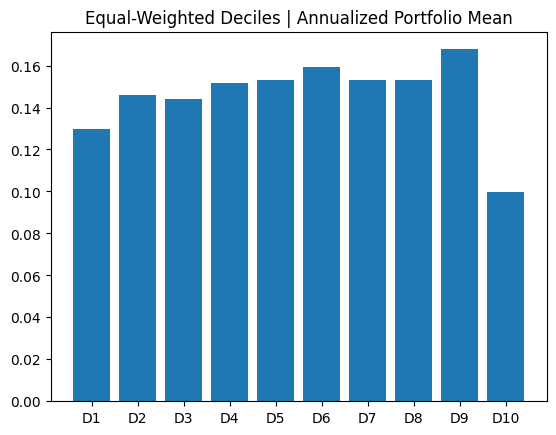

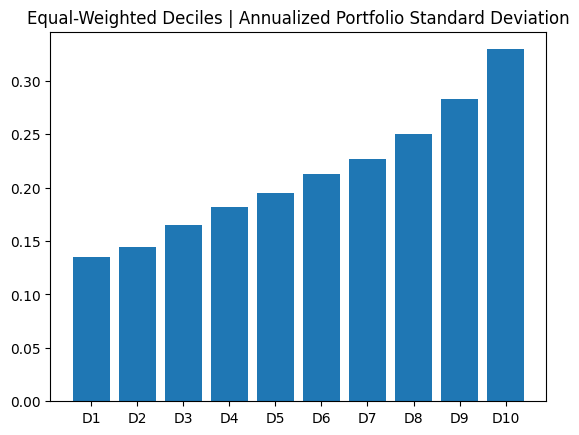

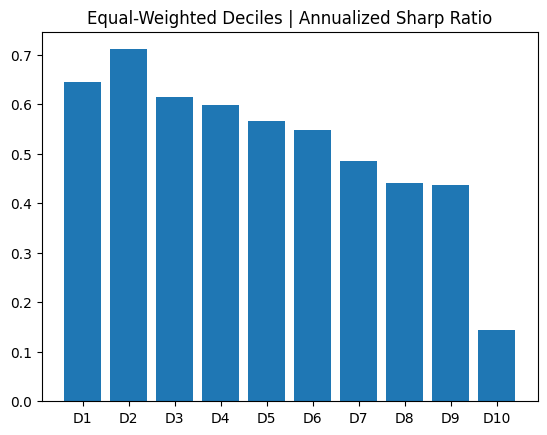

(<BarContainer object of 10 artists>,
 Text(0.5, 1.0, 'Equal-Weighted Deciles | Annualized Sharp Ratio'),
 None)

In [7]:
plt.bar(['D'+ str(x) for x in np.arange(1,11)], ret_ew.groupby('beta_decile')['ew_decile_ret'].mean()*12),plt.title('Equal-Weighted Deciles | Annualized Portfolio Mean'), plt.show()
plt.bar(['D'+ str(x) for x in np.arange(1,11)], ret_ew.groupby('beta_decile')['ew_decile_ret'].std()*np.sqrt(12)),plt.title('Equal-Weighted Deciles | Annualized Portfolio Standard Deviation'), plt.show()
plt.bar(['D'+ str(x) for x in np.arange(1,11)], ret_ew.groupby('beta_decile')['ew_decile_excess_ret'].mean()*np.sqrt(12)/ret_ew.groupby('beta_decile')['ew_decile_ret'].std()),plt.title('Equal-Weighted Deciles | Annualized Sharp Ratio'), plt.show()

#### Value Weighted

In [8]:
data_bab = data_bab.dropna(subset='beta').copy()
data_bab['beta_decile'] = data_bab.groupby('date')['beta'].transform(lambda x: pd.qcut(x, 10,labels=False, duplicates='drop'))

# Compute weights for value-weighted portfolios
data_bab['vw_decile'] = data_bab['mcap'] / data_bab.groupby(['date','beta_decile'])['mcap'].transform('sum')
# Compute returns for each portfolio
data_bab['vw_decile_ret'] = data_bab['vw_decile'] * data_bab['Rn']
data_bab['vw_decile_excess_ret'] = data_bab['vw_decile'] * data_bab['Rn_e']
ret_vw = data_bab.groupby(['date','beta_decile'])['vw_decile_ret'].sum().reset_index()
vw_decile_excess_ret = data_bab.groupby(['date', 'beta_decile'])['vw_decile_excess_ret'].sum().reset_index(name='vw_decile_excess_ret')
ret_vw = ret_vw.merge(vw_decile_excess_ret, on=['date', 'beta_decile'])
ret_vw

,date,beta_decile,vw_decile_ret,vw_decile_excess_ret
0,1967-01-31,0,0.071917,0.068129
1,1967-01-31,1,0.056139,0.052351
2,1967-01-31,2,0.061363,0.057575
3,1967-01-31,3,0.067793,0.064005
4,1967-01-31,4,0.109913,0.106125
...,...,...,...,...
6611,2023-12-29,5,0.081436,0.076952
6612,2023-12-29,6,0.093483,0.088999
6613,2023-12-29,7,0.112129,0.107645
6614,2023-12-29,8,0.121687,0.117202


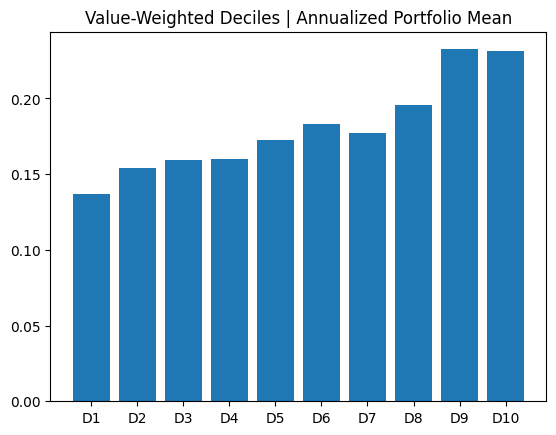

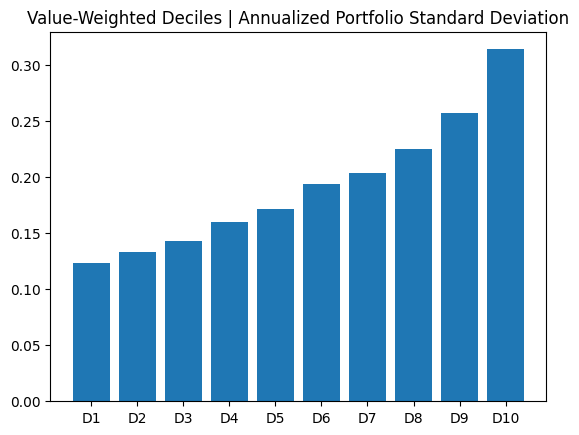

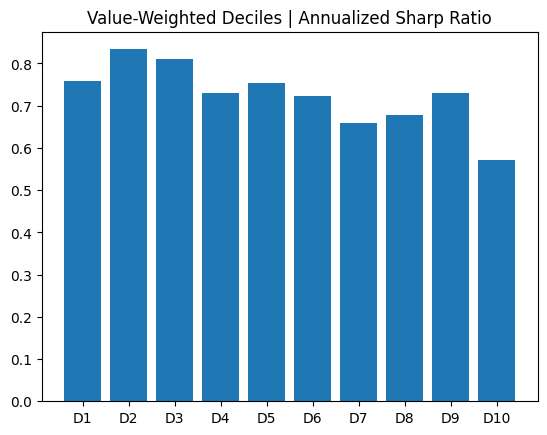

(<BarContainer object of 10 artists>,
 Text(0.5, 1.0, 'Value-Weighted Deciles | Annualized Sharp Ratio'),
 None)

In [9]:
plt.bar(['D'+ str(x) for x in np.arange(1,11)], ret_vw.groupby('beta_decile')['vw_decile_ret'].mean()*12),plt.title('Value-Weighted Deciles | Annualized Portfolio Mean'), plt.show()
plt.bar(['D'+ str(x) for x in np.arange(1,11)], ret_vw.groupby('beta_decile')['vw_decile_ret'].std()*np.sqrt(12)),plt.title('Value-Weighted Deciles | Annualized Portfolio Standard Deviation'), plt.show()
plt.bar(['D'+ str(x) for x in np.arange(1,11)], ret_vw.groupby('beta_decile')['vw_decile_excess_ret'].mean()*np.sqrt(12)/ret_vw.groupby('beta_decile')['vw_decile_ret'].std()),plt.title('Value-Weighted Deciles | Annualized Sharp Ratio'), plt.show()

### Constructing the BAB factor

In [10]:
# Compute z
data_bab['z'] = data_bab.groupby('date')['beta'].transform(lambda x: x.rank())
# Compute z-hat
data_bab['z_mean'] = data_bab.groupby('date')['z'].transform('mean')
# Calculate (z - z-hat)
data_bab['z_'] = data_bab['z'] - data_bab['z_mean']
# Calculate k
data_bab['k'] = np.abs(data_bab['z_'])
data_bab['k'] = 2/data_bab.groupby('date')['k'].transform('sum')
# Compute high-beta and low-beta portfolios weights
data_bab['w_H'] = data_bab['k'] * data_bab['z_'] * (data_bab['z_']>0) 
data_bab['w_L'] = -data_bab['k'] * data_bab['z_'] * (data_bab['z_']<0) 

In [11]:
# Compute betas
data_bab['beta_H'] = data_bab['w_H'] * data_bab['beta']
data_bab['beta_L'] = data_bab['w_L'] * data_bab['beta']
# Compute Excess Returns
data_bab['R_H_e'] = data_bab['w_H'] * data_bab['Rn_e']
data_bab['R_L_e'] = data_bab['w_L'] * data_bab['Rn_e']
# Sum up all returns and betas for each date
BAB = data_bab.groupby('date')[['R_H_e','R_L_e','beta_H','beta_L']].sum().reset_index()
# Compute BAB return
BAB['R_BAB'] = BAB['R_L_e']/BAB['beta_L'] - BAB['R_H_e']/BAB['beta_H'] 


In [12]:
tmp = pd.merge(BAB,data_bab[['date','Rm_e']].drop_duplicates(), on=['date'], how='left')
tmp['const'] = 1
tmp = tmp.dropna()
reg = sm.OLS(tmp['R_BAB'], tmp[['const', 'Rm_e']]).fit()

print('----------------------------------------')
print(f"| Annualized mean          | {np.round(tmp['R_BAB'].mean() * 12, 5)} |")
print(f"| Annualized std           | {np.round(tmp['R_BAB'].std() * np.sqrt(12), 5)}  |")
print(f"| Annualized Sharp Ratio   | {np.round(tmp['R_BAB'].mean() / tmp['R_BAB'].std() * np.sqrt(12), 5)} |")
print(f"| Annualized CAPM alpha    | {np.round(reg.params['const'] * 12, 5)} |")
print(f"| BAB factor               | {np.round(reg.params['Rm_e'], 5)} |")
print('----------------------------------------')

----------------------------------------
| Annualized mean          | 0.11623 |
| Annualized std           | 0.1399  |
| Annualized Sharp Ratio   | 0.83081 |
| Annualized CAPM alpha    | 0.08136 |
| BAB factor               | 0.51369 |
----------------------------------------


## Momentum Strategy (Mom)

In [13]:
data_mom = pd.read_csv('data.csv', sep=';')
data_mom['date'] = pd.to_datetime(data_mom['date'])
data_mom=data_mom.sort_values(['date','permno']).reset_index(drop=True)
data_mom = data_mom.dropna(subset=['mcap_l','Rn_e','Rm_e']).copy()
data_mom['N'] = data_mom.groupby(['permno'])['date'].transform('count')
data_mom = data_mom[data_mom['N']>60].copy() # consider only those that have more than 5-years of data
data_mom

,permno,date,Rn,shrout,prc,mcap,mcap_l,rf,Rm,const,Rn_e,Rm_e,N
0,10006,1964-01-31,0.068548,2948.0,66.25000,1.953050e+05,202675.000,0.002873,0.025790,1,0.065675,0.022917,243
1,10014,1964-01-31,0.000000,3369.0,2.87500,9.685875e+03,9685.875,0.002873,0.025790,1,-0.002873,0.022917,157
3,10057,1964-01-31,0.069915,500.0,62.50000,3.125000e+04,33000.000,0.002873,0.025790,1,0.067042,0.022917,388
4,10102,1964-01-31,0.029083,5032.0,57.50000,2.893400e+05,278018.000,0.002873,0.025790,1,0.026210,0.022917,170
5,10137,1964-01-31,-0.007371,9338.0,50.50000,4.715690e+05,490245.000,0.002873,0.025790,1,-0.010244,0.022917,563
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1439402,93330,2023-12-29,-0.017899,35034.0,205.75999,7.208595e+06,1779000.000,0.004484,0.053468,1,-0.022383,0.048984,163
1439404,93373,2023-12-29,-0.025611,3746.0,8.37000,3.135402e+04,37635.700,0.004484,0.053468,1,-0.030095,0.048984,162
1439405,93374,2023-12-29,0.090101,103181.0,64.44000,6.648984e+06,4144644.540,0.004484,0.053468,1,0.085617,0.048984,161
1439406,93423,2023-12-29,0.007229,83537.0,25.08000,2.095108e+06,1933400.250,0.004484,0.053468,1,0.002745,0.048984,161


### Portfolio Sorts

In [14]:
# Compute cumulative return for each permco
tmp = data_mom.set_index('date').groupby('permno')['Rn'].rolling(window=11, closed='left').apply(lambda x: (1 + x).prod() - 1).reset_index()
tmp = tmp.dropna()
tmp = tmp.reset_index().rename(columns={'Rn': 'lagged_11_month_ret'})
data_mom = pd.merge(data_mom, tmp, on=['date','permno'], how='left')
# Compute Deciles of returns for each date
data_mom['lagged_11_month_ret_decile'] = data_mom.groupby('date')['lagged_11_month_ret'].transform(lambda x: pd.qcut(x, 10, labels=False, duplicates='drop'))

#### Equally Weighted 

In [15]:
# Calculate weights for equal-weighted portfolios for date-decile pair
data_mom['ew_lagged_decile'] = 1 / data_mom.groupby(['date','lagged_11_month_ret_decile'])['permno'].transform('count')
# Compute returns of each portfolio
data_mom['ew_lagged_decile_ret'] = data_mom['ew_lagged_decile'] * data_mom['Rn']
data_mom['ew_lagged_decile_excess_ret'] = data_mom['ew_lagged_decile'] * data_mom['Rn_e']
ret_ew_lagged = data_mom.groupby(['date','lagged_11_month_ret_decile'])['ew_lagged_decile_ret'].sum().reset_index()
# Excess return
ew_lagged_decile_excess_ret = data_mom.groupby(['date', 'lagged_11_month_ret_decile'])['ew_lagged_decile_excess_ret'].sum().reset_index(name='ew_lagged_decile_excess_ret')
ret_ew_lagged = ret_ew_lagged.merge(ew_lagged_decile_excess_ret, on=['date', 'lagged_11_month_ret_decile'])
ret_ew_lagged

,date,lagged_11_month_ret_decile,ew_lagged_decile_ret,ew_lagged_decile_excess_ret
0,1964-12-31,0.0,-0.036680,-0.039536
1,1964-12-31,1.0,-0.011736,-0.014592
2,1964-12-31,2.0,-0.003629,-0.006485
3,1964-12-31,3.0,0.004180,0.001324
4,1964-12-31,4.0,-0.011839,-0.014695
...,...,...,...,...
7075,2023-12-29,5.0,0.068032,0.063547
7076,2023-12-29,6.0,0.077761,0.073277
7077,2023-12-29,7.0,0.069357,0.064872
7078,2023-12-29,8.0,0.098510,0.094026


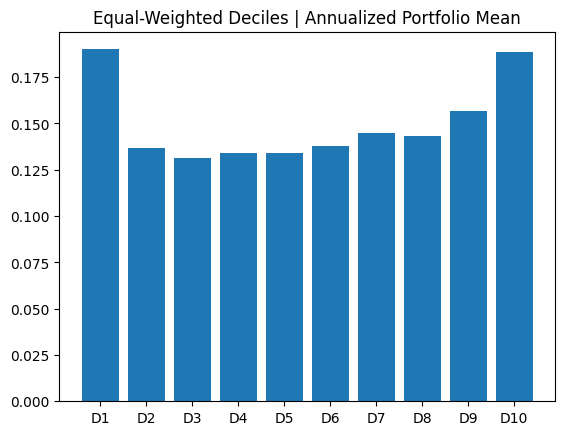

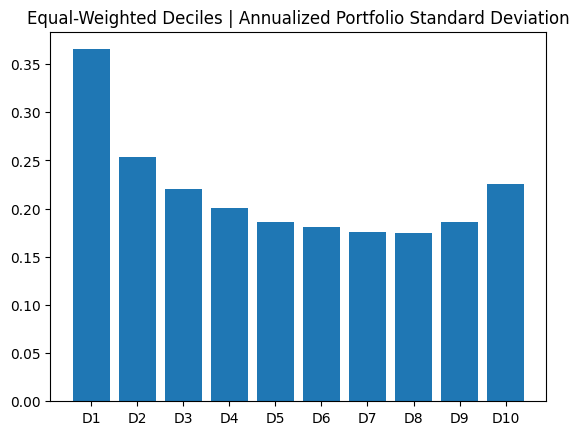

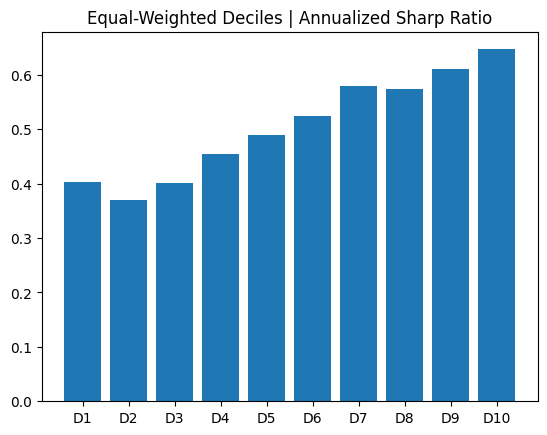

(<BarContainer object of 10 artists>,
 Text(0.5, 1.0, 'Equal-Weighted Deciles | Annualized Sharp Ratio'),
 None)

In [16]:
plt.bar(['D'+ str(x) for x in np.arange(1,11)], ret_ew_lagged.groupby('lagged_11_month_ret_decile')['ew_lagged_decile_ret'].mean()*12),plt.title('Equal-Weighted Deciles | Annualized Portfolio Mean'), plt.show()
plt.bar(['D'+ str(x) for x in np.arange(1,11)], ret_ew_lagged.groupby('lagged_11_month_ret_decile')['ew_lagged_decile_ret'].std()*np.sqrt(12)),plt.title('Equal-Weighted Deciles | Annualized Portfolio Standard Deviation'), plt.show()
plt.bar(['D'+ str(x) for x in np.arange(1,11)], ret_ew_lagged.groupby('lagged_11_month_ret_decile')['ew_lagged_decile_excess_ret'].mean()*np.sqrt(12)/ret_ew_lagged.groupby('lagged_11_month_ret_decile')['ew_lagged_decile_ret'].std()),plt.title('Equal-Weighted Deciles | Annualized Sharp Ratio'), plt.show()

#### Value Weighted

In [17]:
# Compute weights for value-weighted portfolios
data_mom['vw_lagged_decile'] = data_mom['mcap'] / data_mom.groupby(['date','lagged_11_month_ret_decile'])['mcap'].transform('sum')
# Compute returns for each portfolio
data_mom['vw_lagged_decile_ret'] = data_mom['vw_lagged_decile'] * data_mom['Rn']
data_mom['vw_lagged_decile_excess_ret'] = data_mom['vw_lagged_decile'] * data_mom['Rn_e']
ret_vw_lagged = data_mom.groupby(['date','lagged_11_month_ret_decile'])['vw_lagged_decile_ret'].sum().reset_index()
vw_lagged_decile_excess_ret = data_mom.groupby(['date', 'lagged_11_month_ret_decile'])['vw_lagged_decile_excess_ret'].sum().reset_index(name='vw_lagged_decile_excess_ret')
ret_vw_lagged = ret_vw_lagged.merge(vw_lagged_decile_excess_ret, on=['date', 'lagged_11_month_ret_decile'])
ret_vw_lagged

,date,lagged_11_month_ret_decile,vw_lagged_decile_ret,vw_lagged_decile_excess_ret
0,1964-12-31,0.0,-0.004366,-0.007222
1,1964-12-31,1.0,0.004115,0.001259
2,1964-12-31,2.0,0.015191,0.012335
3,1964-12-31,3.0,0.012432,0.009577
4,1964-12-31,4.0,0.002724,-0.000131
...,...,...,...,...
7075,2023-12-29,5.0,0.024805,0.020321
7076,2023-12-29,6.0,0.045753,0.041269
7077,2023-12-29,7.0,0.038884,0.034400
7078,2023-12-29,8.0,0.080874,0.076389


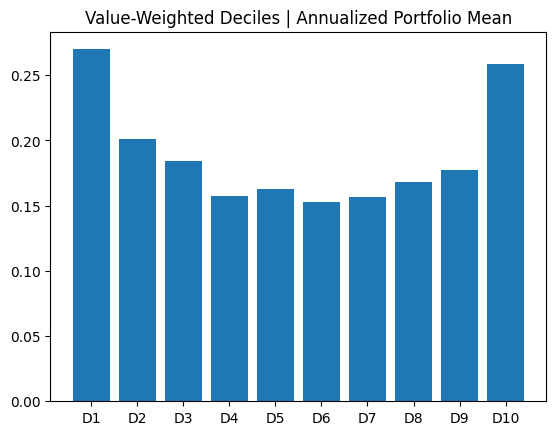

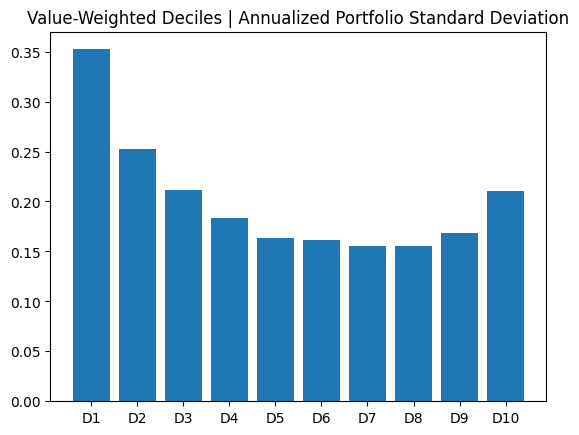

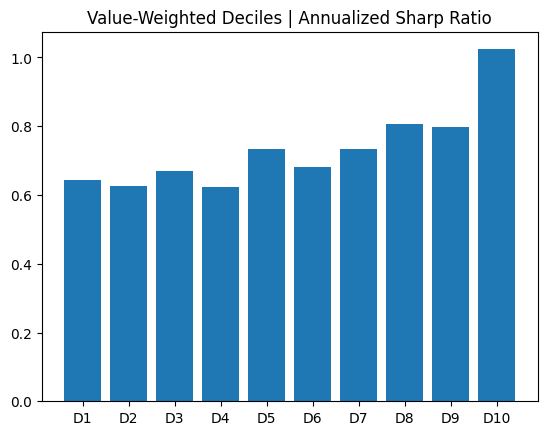

(<BarContainer object of 10 artists>,
 Text(0.5, 1.0, 'Value-Weighted Deciles | Annualized Sharp Ratio'),
 None)

In [18]:
plt.bar(['D'+ str(x) for x in np.arange(1,11)], ret_vw_lagged.groupby('lagged_11_month_ret_decile')['vw_lagged_decile_ret'].mean()*12),plt.title('Value-Weighted Deciles | Annualized Portfolio Mean'), plt.show()
plt.bar(['D'+ str(x) for x in np.arange(1,11)], ret_vw_lagged.groupby('lagged_11_month_ret_decile')['vw_lagged_decile_ret'].std()*np.sqrt(12)),plt.title('Value-Weighted Deciles | Annualized Portfolio Standard Deviation'), plt.show()
plt.bar(['D'+ str(x) for x in np.arange(1,11)], ret_vw_lagged.groupby('lagged_11_month_ret_decile')['vw_lagged_decile_excess_ret'].mean()*np.sqrt(12)/ret_vw_lagged.groupby('lagged_11_month_ret_decile')['vw_lagged_decile_ret'].std()),plt.title('Value-Weighted Deciles | Annualized Sharp Ratio'), plt.show()

### Momentum Strategy Portfolio

In [19]:
def calculate_portfolio_metrics(returns, excess_returns):
    mean_return = returns.mean() * 12
    std_dev = returns.std() * np.sqrt(12)
    sharpe_ratio = excess_returns.mean() * 12 / std_dev
    return mean_return, std_dev, sharpe_ratio

In [20]:
long = data_mom[data_mom['lagged_11_month_ret_decile'].isin([7,8,9])].copy()
short = data_mom[data_mom['lagged_11_month_ret_decile'].isin([0,1,2])].copy()

#### Equally Weighted Portfolio

In [21]:
# Long portfolio: Equal-weighted average of the top three deciles (Deciles 7, 8 and 9)
ew_long_rets = long.groupby('date')['Rn'].mean() 
ew_long_excess_rets = long.groupby('date')['Rn_e'].mean() 
# Short portfolio: Equal-weighted average of the bottom three deciles (Deciles 0, 1 and 2)
ew_short_rets = short.groupby('date')['Rn'].mean() 
ew_short_excess_rets = short.groupby('date')['Rn_e'].mean() 
# Compute the return of the momentum strategy as the difference between the long and short portfolios' returns
ew_momentum_rets = ew_long_rets - ew_short_rets

In [22]:
ew_long_mean, ew_long_std, ew_long_sharpe = calculate_portfolio_metrics(ew_long_rets, ew_long_excess_rets)
ew_short_mean, ew_short_std, ew_short_sharpe = calculate_portfolio_metrics(ew_short_rets, ew_short_excess_rets)
ew_momentum_mean, ew_momentum_std, ew_momentum_sharpe = calculate_portfolio_metrics(ew_momentum_rets, ew_long_excess_rets - ew_short_excess_rets)
ew_t_stat, ew_p_value = stats.ttest_1samp(ew_momentum_rets, 0)

print(f"Equal-Weighted Portfolio Metrics:")
print(f"Long Portfolio: Mean = {ew_long_mean:.3%}, Std Dev = {ew_long_std:.3%}, Sharpe Ratio = {ew_long_sharpe:.3f}")
print(f"Short Portfolio: Mean = {ew_short_mean:.3%}, Std Dev = {ew_short_std:.3%}, Sharpe Ratio = {ew_short_sharpe:.3f}")
print(f"Momentum Strategy: Mean = {ew_momentum_mean:.3%}, Std Dev = {ew_momentum_std:.3%}, Sharpe Ratio = {ew_momentum_sharpe:.3f}")
print(f"T-statistic = {ew_t_stat:.2f}, P-value = {ew_p_value:.4f}\n")

Equal-Weighted Portfolio Metrics:
Long Portfolio: Mean = 16.307%, Std Dev = 19.109%, Sharpe Ratio = 0.628
Short Portfolio: Mean = 15.280%, Std Dev = 27.259%, Sharpe Ratio = 0.403
Momentum Strategy: Mean = 1.027%, Std Dev = 17.727%, Sharpe Ratio = 0.058
T-statistic = 0.44, P-value = 0.6565



#### Value Weighted Portfolio

In [23]:
# Long portfolio: Value-weighted average of the top three deciles (Deciles 7, 8 and 9)
long_weights = long['mcap'] / long.groupby('date')['mcap'].transform('sum')
long['vw_rets'] = long_weights * long['Rn']
vw_long_rets = long.groupby('date')['vw_rets'].sum()
long['vw_excess_rets'] = long_weights * long['Rn_e']
vw_long_excess_rets = long.groupby('date')['vw_excess_rets'].sum()
# Short portfolio: Value-weighted average of the bottom three deciles (Deciles 0, 1 and 2)
short_weights = short['mcap'] / short.groupby('date')['mcap'].transform('sum')
short['vw_rets'] = short_weights * short['Rn']
vw_short_rets = short.groupby('date')['vw_rets'].sum()
short['vw_excess_rets'] = short_weights * short['Rn_e']
vw_short_excess_rets = short.groupby('date')['vw_excess_rets'].sum()
# Compute the return of the momentum strategy as the difference between the long and short portfolios' returns
vw_momentum_rets = vw_long_rets - vw_short_rets

In [24]:
vw_long_mean, vw_long_std, vw_long_sharpe = calculate_portfolio_metrics(vw_long_rets, vw_long_excess_rets)
vw_short_mean, vw_short_std, vw_short_sharpe = calculate_portfolio_metrics(vw_short_rets, vw_short_excess_rets)
vw_momentum_mean, vw_momentum_std, vw_momentum_sharpe = calculate_portfolio_metrics(vw_momentum_rets, vw_long_excess_rets - vw_short_excess_rets)
vw_t_stat, vw_p_value = stats.ttest_1samp(vw_momentum_rets, 0)

print(f"Value-Weighted Portfolio Metrics:")
print(f"Long Portfolio: Mean = {vw_long_mean:.3%}, Std Dev = {vw_long_std:.3%}, Sharpe Ratio = {vw_long_sharpe:.3f}")
print(f"Short Portfolio: Mean = {vw_short_mean:.3%}, Std Dev = {vw_short_std:.3%}, Sharpe Ratio = {vw_short_sharpe:.3f}")
print(f"Momentum Strategy: Mean = {vw_momentum_mean:.3%}, Std Dev = {vw_momentum_std:.3%}, Sharpe Ratio = {vw_momentum_sharpe:.3f}")
print(f"T-statistic = {vw_t_stat:.2f}, P-value = {vw_p_value:.4f}\n")

Value-Weighted Portfolio Metrics:
Long Portfolio: Mean = 18.905%, Std Dev = 16.253%, Sharpe Ratio = 0.899
Short Portfolio: Mean = 20.239%, Std Dev = 23.383%, Sharpe Ratio = 0.682
Momentum Strategy: Mean = -1.334%, Std Dev = 18.587%, Sharpe Ratio = -0.072
T-statistic = -0.55, P-value = 0.5815



## Idiosyncratic Volatility Strategy (IV)

In [25]:
data_iv = pd.read_csv('data.csv', sep=';')
data_iv['date'] = pd.to_datetime(data_iv['date'])
data_iv=data_iv.sort_values(['date','permno']).reset_index(drop=True)
data_iv = data_iv.dropna(subset=['mcap_l','Rn_e','Rm_e']).copy()
data_iv['N'] = data_iv.groupby(['permno'])['date'].transform('count')
data_iv = data_iv[data_iv['N']>60].copy() # consider only those that have more than 5-years of data
data_iv

,permno,date,Rn,shrout,prc,mcap,mcap_l,rf,Rm,const,Rn_e,Rm_e,N
0,10006,1964-01-31,0.068548,2948.0,66.25000,1.953050e+05,202675.000,0.002873,0.025790,1,0.065675,0.022917,243
1,10014,1964-01-31,0.000000,3369.0,2.87500,9.685875e+03,9685.875,0.002873,0.025790,1,-0.002873,0.022917,157
3,10057,1964-01-31,0.069915,500.0,62.50000,3.125000e+04,33000.000,0.002873,0.025790,1,0.067042,0.022917,388
4,10102,1964-01-31,0.029083,5032.0,57.50000,2.893400e+05,278018.000,0.002873,0.025790,1,0.026210,0.022917,170
5,10137,1964-01-31,-0.007371,9338.0,50.50000,4.715690e+05,490245.000,0.002873,0.025790,1,-0.010244,0.022917,563
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1439402,93330,2023-12-29,-0.017899,35034.0,205.75999,7.208595e+06,1779000.000,0.004484,0.053468,1,-0.022383,0.048984,163
1439404,93373,2023-12-29,-0.025611,3746.0,8.37000,3.135402e+04,37635.700,0.004484,0.053468,1,-0.030095,0.048984,162
1439405,93374,2023-12-29,0.090101,103181.0,64.44000,6.648984e+06,4144644.540,0.004484,0.053468,1,0.085617,0.048984,161
1439406,93423,2023-12-29,0.007229,83537.0,25.08000,2.095108e+06,1933400.250,0.004484,0.053468,1,0.002745,0.048984,161


### Idiosyncratic volatility

In [26]:
window_size = 60 # 5-year rolling window
#Compute covariance matrix of excess stock and market returns
cov_nm = data_iv.set_index('date').groupby('permno')[['Rn_e','Rm_e']].rolling(window_size, min_periods=36).cov()
# Compute idiosyncratic risk from OLS regression (VAR(Rn_e) - COV(Rn_e, Rm_e)^2/VAR(Rm_e))
risk_idio = cov_nm.iloc[0::2,0].droplevel(2)
risk_idio = risk_idio.reset_index().rename(columns={'Rn_e': 'tot_risk_squared'})
risk_sys = cov_nm.iloc[0::2,1].droplevel(2) ** 2 / cov_nm.iloc[1::2,1].droplevel(2)
risk_sys = risk_sys.reset_index().rename(columns={'Rm_e': 'sys_risk_squared'})
risk_idio = pd.merge(risk_idio, risk_sys, on=['date','permno'], how='left')
risk_idio['idio_risk_squared'] = risk_idio['tot_risk_squared'] - risk_idio['sys_risk_squared']
risk_idio['idio_risk'] = np.sqrt(risk_idio['idio_risk_squared'])
risk_idio = risk_idio.drop(columns=['sys_risk_squared', 'idio_risk_squared', 'tot_risk_squared'])
# Merge idiosyncratic risk dataframe into data dataframe
risk_idio = risk_idio.set_index(['date', 'permno']).groupby('permno').shift(1)
risk_idio = risk_idio.dropna().reset_index()
data_iv = pd.merge(data_iv, risk_idio, on=['date','permno'], how='left')

# Winsorize the idiosyncratic risk at 5 and 95%
data_iv['idio_risk'] = data_iv['idio_risk'].clip(lower = data_iv['idio_risk'].quantile(0.05), upper = data_iv['idio_risk'].quantile(0.95))
data_iv = data_iv.dropna(subset='idio_risk').copy()
data_iv

,permno,date,Rn,shrout,prc,mcap,mcap_l,rf,Rm,const,Rn_e,Rm_e,N,idio_risk
58824,10006,1967-01-31,0.140523,5748.0,43.62500,2.507565e+05,238542.00,0.003788,0.085530,1,0.136735,0.081742,243,0.044745
58825,10014,1967-01-31,0.321429,3372.0,4.62500,1.559550e+04,15595.50,0.003788,0.085530,1,0.317641,0.081742,157,0.097687
58826,10057,1967-01-31,0.146104,1014.0,44.12500,4.474275e+04,43348.50,0.003788,0.085530,1,0.142316,0.081742,388,0.056330
58827,10102,1967-01-31,0.105364,5176.0,72.12500,3.733190e+05,380436.00,0.003788,0.085530,1,0.101576,0.081742,170,0.052335
58828,10137,1967-01-31,-0.045045,19292.0,26.50000,5.112380e+05,511238.00,0.003788,0.085530,1,-0.048833,0.081742,563,0.044745
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1321751,93330,2023-12-29,-0.017899,35034.0,205.75999,7.208595e+06,1779000.00,0.004484,0.053468,1,-0.022383,0.048984,163,0.056936
1321752,93373,2023-12-29,-0.025611,3746.0,8.37000,3.135402e+04,37635.70,0.004484,0.053468,1,-0.030095,0.048984,162,0.207283
1321753,93374,2023-12-29,0.090101,103181.0,64.44000,6.648984e+06,4144644.54,0.004484,0.053468,1,0.085617,0.048984,161,0.046390
1321754,93423,2023-12-29,0.007229,83537.0,25.08000,2.095108e+06,1933400.25,0.004484,0.053468,1,0.002745,0.048984,161,0.116407


### Portfolio Sorts

#### Equally Weighted

In [27]:
# Compute idio_risk decile for each date
data_iv['idio_risk_decile'] = data_iv.groupby('date')['idio_risk'].transform(lambda x: pd.qcut(x, 10,labels=False, duplicates='drop'))
# Compute weight for equal-weight porfolio for each date-decile portfolio
data_iv['ew_decile'] = 1 / data_iv.groupby(['date','idio_risk_decile'])['permno'].transform('count')

# Compute weighted return of each portfolio
data_iv['ew_decile_ret'] = data_iv['ew_decile'] * data_iv['Rn']
data_iv['ew_decile_excess_ret'] = data_iv['ew_decile'] * data_iv['Rn_e']
ret_ew = data_iv.groupby(['date','idio_risk_decile'])['ew_decile_ret'].sum().reset_index()

# Compute excess return
ew_decile_excess_ret = data_iv.groupby(['date', 'idio_risk_decile'])['ew_decile_excess_ret'].sum().reset_index(name='ew_decile_excess_ret')
ret_ew = ret_ew.merge(ew_decile_excess_ret, on=['date', 'idio_risk_decile'])
ret_ew

,date,idio_risk_decile,ew_decile_ret,ew_decile_excess_ret
0,1967-01-31,0,0.084983,0.081195
1,1967-01-31,1,0.108426,0.104638
2,1967-01-31,2,0.136671,0.132883
3,1967-01-31,3,0.130373,0.126585
4,1967-01-31,4,0.159298,0.155510
...,...,...,...,...
6648,2023-12-29,4,0.105635,0.101150
6649,2023-12-29,5,0.113660,0.109176
6650,2023-12-29,6,0.138320,0.133836
6651,2023-12-29,7,0.092877,0.088392


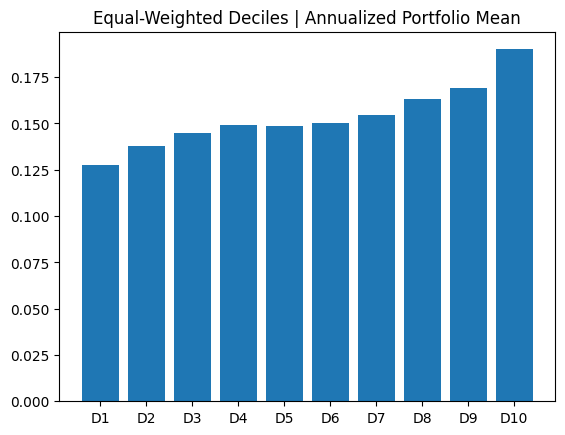

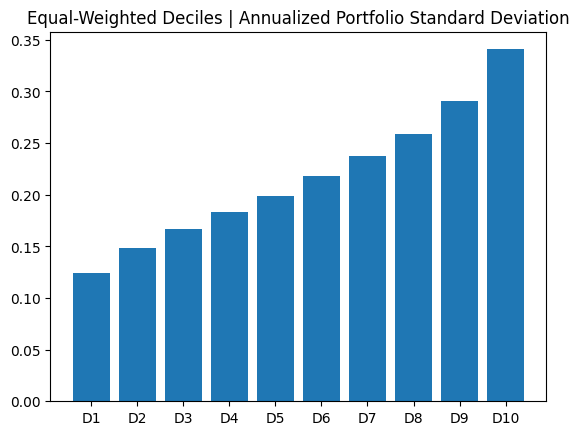

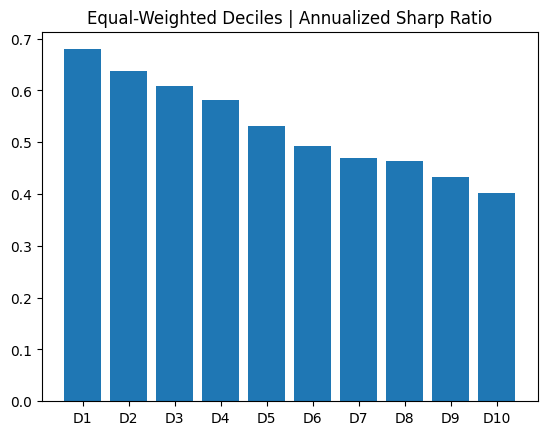

(<BarContainer object of 10 artists>,
 Text(0.5, 1.0, 'Equal-Weighted Deciles | Annualized Sharp Ratio'),
 None)

In [28]:
plt.bar(['D'+ str(x) for x in np.arange(1,11)], ret_ew.groupby('idio_risk_decile')['ew_decile_ret'].mean()*12),plt.title('Equal-Weighted Deciles | Annualized Portfolio Mean'), plt.show()
plt.bar(['D'+ str(x) for x in np.arange(1,11)], ret_ew.groupby('idio_risk_decile')['ew_decile_ret'].std()*np.sqrt(12)),plt.title('Equal-Weighted Deciles | Annualized Portfolio Standard Deviation'), plt.show()
plt.bar(['D'+ str(x) for x in np.arange(1,11)], ret_ew.groupby('idio_risk_decile')['ew_decile_excess_ret'].mean()*np.sqrt(12)/ret_ew.groupby('idio_risk_decile')['ew_decile_ret'].std()),plt.title('Equal-Weighted Deciles | Annualized Sharp Ratio'), plt.show()

#### Value Weighted

In [29]:
data_iv = data_iv.dropna(subset='idio_risk').copy()
data_iv['idio_risk_decile'] = data_iv.groupby('date')['idio_risk'].transform(lambda x: pd.qcut(x, 10,labels=False, duplicates='drop'))

# Compute weights for value-weighted portfolios
data_iv['vw_decile'] = data_iv['mcap'] / data_iv.groupby(['date','idio_risk_decile'])['mcap'].transform('sum')
# Compute returns for each portfolio
data_iv['vw_decile_ret'] = data_iv['vw_decile'] * data_iv['Rn']
data_iv['vw_decile_excess_ret'] = data_iv['vw_decile'] * data_iv['Rn_e']
ret_vw = data_iv.groupby(['date','idio_risk_decile'])['vw_decile_ret'].sum().reset_index()
vw_decile_excess_ret = data_iv.groupby(['date', 'idio_risk_decile'])['vw_decile_excess_ret'].sum().reset_index(name='vw_decile_excess_ret')
ret_vw = ret_vw.merge(vw_decile_excess_ret, on=['date', 'idio_risk_decile'])
ret_vw

,date,idio_risk_decile,vw_decile_ret,vw_decile_excess_ret
0,1967-01-31,0,0.067076,0.063288
1,1967-01-31,1,0.096155,0.092367
2,1967-01-31,2,0.101218,0.097430
3,1967-01-31,3,0.102036,0.098248
4,1967-01-31,4,0.120662,0.116874
...,...,...,...,...
6648,2023-12-29,4,0.054058,0.049574
6649,2023-12-29,5,0.090306,0.085822
6650,2023-12-29,6,0.090265,0.085781
6651,2023-12-29,7,0.103783,0.099299


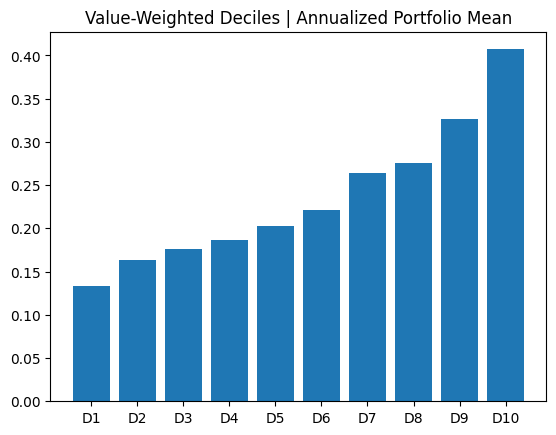

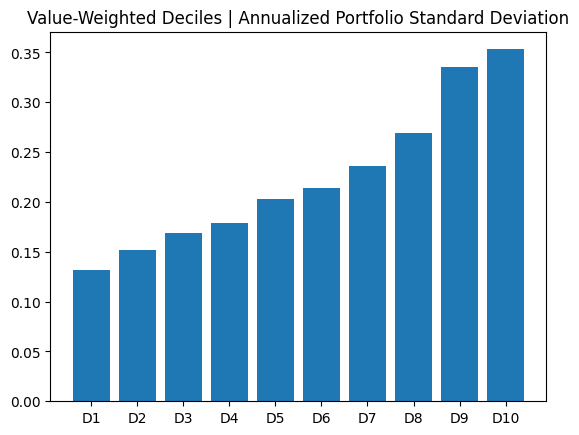

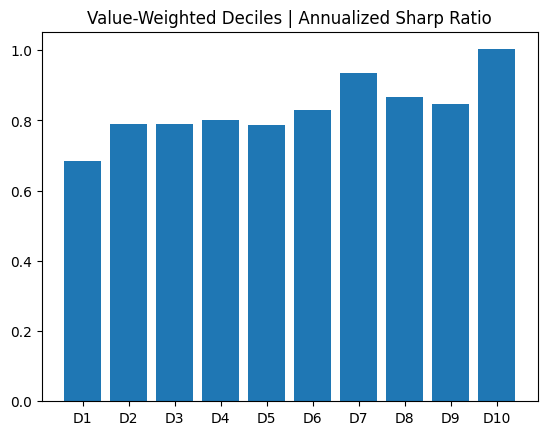

(<BarContainer object of 10 artists>,
 Text(0.5, 1.0, 'Value-Weighted Deciles | Annualized Sharp Ratio'),
 None)

In [30]:
plt.bar(['D'+ str(x) for x in np.arange(1,11)], ret_vw.groupby('idio_risk_decile')['vw_decile_ret'].mean()*12),plt.title('Value-Weighted Deciles | Annualized Portfolio Mean'), plt.show()
plt.bar(['D'+ str(x) for x in np.arange(1,11)], ret_vw.groupby('idio_risk_decile')['vw_decile_ret'].std()*np.sqrt(12)),plt.title('Value-Weighted Deciles | Annualized Portfolio Standard Deviation'), plt.show()
plt.bar(['D'+ str(x) for x in np.arange(1,11)], ret_vw.groupby('idio_risk_decile')['vw_decile_excess_ret'].mean()*np.sqrt(12)/ret_vw.groupby('idio_risk_decile')['vw_decile_ret'].std()),plt.title('Value-Weighted Deciles | Annualized Sharp Ratio'), plt.show()

### Idiosyncratic Volatility Portfolio

In [31]:
long = data_iv[data_iv['idio_risk_decile'].isin([7,8,9])].copy()
short = data_iv[data_iv['idio_risk_decile'].isin([0,1,2])].copy()

#### Equally Weighted Portfolio

In [32]:
# Long portfolio: Equal-weighted average of the top three deciles (Deciles 7, 8 and 9)
ew_long_rets = long.groupby('date')['Rn'].mean() 
ew_long_excess_rets = long.groupby('date')['Rn_e'].mean() 
# Short portfolio: Equal-weighted average of the bottom three deciles (Deciles 0, 1 and 2)
ew_short_rets = short.groupby('date')['Rn'].mean() 
ew_short_excess_rets = short.groupby('date')['Rn_e'].mean() 
# Compute the return of the momentum strategy as the difference between the long and short portfolios' returns
ew_momentum_rets = ew_long_rets - ew_short_rets

In [33]:
ew_long_mean, ew_long_std, ew_long_sharpe = calculate_portfolio_metrics(ew_long_rets, ew_long_excess_rets)
ew_short_mean, ew_short_std, ew_short_sharpe = calculate_portfolio_metrics(ew_short_rets, ew_short_excess_rets)
ew_momentum_mean, ew_momentum_std, ew_momentum_sharpe = calculate_portfolio_metrics(ew_momentum_rets, ew_long_excess_rets - ew_short_excess_rets)
ew_t_stat, ew_p_value = stats.ttest_1samp(ew_momentum_rets, 0)

print(f"Equal-Weighted Portfolio Metrics:")
print(f"Long Portfolio: Mean = {ew_long_mean:.3%}, Std Dev = {ew_long_std:.3%}, Sharpe Ratio = {ew_long_sharpe:.3f}")
print(f"Short Portfolio: Mean = {ew_short_mean:.3%}, Std Dev = {ew_short_std:.3%}, Sharpe Ratio = {ew_short_sharpe:.3f}")
print(f"Momentum Strategy: Mean = {ew_momentum_mean:.3%}, Std Dev = {ew_momentum_std:.3%}, Sharpe Ratio = {ew_momentum_sharpe:.3f}")
print(f"T-statistic = {ew_t_stat:.2f}, P-value = {ew_p_value:.4f}\n")

Equal-Weighted Portfolio Metrics:
Long Portfolio: Mean = 16.829%, Std Dev = 28.434%, Sharpe Ratio = 0.441
Short Portfolio: Mean = 13.652%, Std Dev = 14.273%, Sharpe Ratio = 0.655
Momentum Strategy: Mean = 3.177%, Std Dev = 19.542%, Sharpe Ratio = 0.163
T-statistic = 1.23, P-value = 0.2205



#### Value Weighted Portfolio

In [34]:
# Long portfolio: Value-weighted average of the top three deciles (Deciles 7, 8 and 9)
long_weights = long['mcap'] / long.groupby('date')['mcap'].transform('sum')
long['vw_rets'] = long_weights * long['Rn']
vw_long_rets = long.groupby('date')['vw_rets'].sum()
long['vw_excess_rets'] = long_weights * long['Rn_e']
vw_long_excess_rets = long.groupby('date')['vw_excess_rets'].sum()
# Short portfolio: Value-weighted average of the bottom three deciles (Deciles 0, 1 and 2)
short_weights = short['mcap'] / short.groupby('date')['mcap'].transform('sum')
short['vw_rets'] = short_weights * short['Rn']
vw_short_rets = short.groupby('date')['vw_rets'].sum()
short['vw_excess_rets'] = short_weights * short['Rn_e']
vw_short_excess_rets = short.groupby('date')['vw_excess_rets'].sum()
# Compute the return of the momentum strategy as the difference between the long and short portfolios' returns
vw_momentum_rets = vw_long_rets - vw_short_rets

In [35]:
vw_long_mean, vw_long_std, vw_long_sharpe = calculate_portfolio_metrics(vw_long_rets, vw_long_excess_rets)
vw_short_mean, vw_short_std, vw_short_sharpe = calculate_portfolio_metrics(vw_short_rets, vw_short_excess_rets)
vw_momentum_mean, vw_momentum_std, vw_momentum_sharpe = calculate_portfolio_metrics(vw_momentum_rets, vw_long_excess_rets - vw_short_excess_rets)
vw_t_stat, vw_p_value = stats.ttest_1samp(vw_momentum_rets, 0)

print(f"Value-Weighted Portfolio Metrics:")
print(f"Long Portfolio: Mean = {vw_long_mean:.3%}, Std Dev = {vw_long_std:.3%}, Sharpe Ratio = {vw_long_sharpe:.3f}")
print(f"Short Portfolio: Mean = {vw_short_mean:.3%}, Std Dev = {vw_short_std:.3%}, Sharpe Ratio = {vw_short_sharpe:.3f}")
print(f"Momentum Strategy: Mean = {vw_momentum_mean:.3%}, Std Dev = {vw_momentum_std:.3%}, Sharpe Ratio = {vw_momentum_sharpe:.3f}")
print(f"T-statistic = {vw_t_stat:.2f}, P-value = {vw_p_value:.4f}\n")

Value-Weighted Portfolio Metrics:
Long Portfolio: Mean = 30.648%, Std Dev = 28.310%, Sharpe Ratio = 0.931
Short Portfolio: Mean = 14.980%, Std Dev = 13.963%, Sharpe Ratio = 0.765
Momentum Strategy: Mean = 15.669%, Std Dev = 21.063%, Sharpe Ratio = 0.744
T-statistic = 5.61, P-value = 0.0000

